In [2]:
!pip install mediapipe

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
  Using cached mediapipe-0.8.8.1-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (34.0 MB)
  Using cached opencv_contrib_python-4.5.4.58-cp37-cp37m-manylinux2014_x86_64.whl (66.5 MB)
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.


In [3]:
!apt-get update && apt-get install -y python3-opencv

Get:1 http://security.debian.org/debian-security buster/updates InRelease [65.4 kB]
Hit:2 http://deb.debian.org/debian buster InRelease       
Get:3 http://deb.debian.org/debian buster-updates InRelease [51.9 kB]
Fetched 117 kB in 0s (445 kB/s)      
Reading package lists... Done
Reading package lists... Done
Building dependency tree       
Reading state information... Done
python3-opencv is already the newest version (3.2.0+dfsg-6).
0 upgraded, 0 newly installed, 0 to remove and 50 not upgraded.


In [4]:
!cd yolov5 && pip install -r requirements.txt > /dev/null

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.


In [18]:
import os
import json
import torch
import cv2
from tqdm import tqdm


from detection.yolov5.utils.general import non_max_suppression, scale_coords, xyxy2xywh
from detection.yolov5.utils.augmentations import letterbox
from detection.yolov5.models.experimental import attempt_load

image_dic = dict()

def preprocess(path_to_img, img_size, device):
    print(path_to_img)
    orig_img = cv2.imread(path_to_img)
    print(orig_img.shape)
    orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
    img = letterbox(orig_img, img_size, auto=False)[0]
    img = img.transpose(2, 0, 1)
    img_tensor = torch.from_numpy(img).float().to(device)
    img_tensor /= 255
    img_tensor = img_tensor.unsqueeze(0)
    return img_tensor, list(orig_img.shape), list(img_tensor.shape)


def postprocess(
    out,
    tensor_shape,
    orig_shape,
    path_to_img,
    conf_thres=0.6,
    iou_thres=0.6,
    counter = 1,
):
    out = non_max_suppression(out, conf_thres, iou_thres)
    img_predict = []
    
    for pred in out:
        pred[:, :4] = scale_coords(tensor_shape[2:], pred[:, :4], orig_shape).round()
        box = xyxy2xywh(pred[:, :4])  # xywh
        box[:, :2] -= box[:, 2:] / 2
        for p, b in zip(pred.tolist(), box.tolist()):
            img_predict.append(
                {
                    "id" : counter,
                    "image_id": int(1),
                    "category_id": 1,
                    "segmentation":[],
                    "area":b[2] * b[3],
                    "bbox": [int(x) for x in b],
                    "iscrowd": 0,
                    "attributes":{"occluded":False}
                }
            )
            counter += 1
    return img_predict, counter


def get_img_predict(model, path_to_img, device, img_size, counter = 1):
    img_tensor, orig_shape, tensor_shape = preprocess(path_to_img, img_size, device)
    with torch.no_grad():
        out, _ = model(img_tensor, augment=False)
    img_predict, counter = postprocess(out, tensor_shape, orig_shape, path_to_img,counter = counter)
    return img_predict, counter


def get_detection_solution(
    path_to_weights ='yolov5/runs/train/exp2048/weights/best.pt' , path_to_test_images = "data_task2/test/images", path_to_dt_ann = 'detection_predictions.json', device = None, img_size = 2048,
    sample_path = 'data_task2/submission_example.json'
):
    detect_model = attempt_load(path_to_weights, map_location=device)
    detect_model.eval()
    result = []
    counter = 1
    file_name = path_to_test_images
    img_predict, counter = get_img_predict(
        detect_model, path_to_test_images, device, img_size, counter
    )
    return img_predict


In [1]:
import os
import numpy as np
import pandas as pd

IMG_LIST = os.listdir('data_task2/train/images')

In [2]:
labels = []
names = []
for i in IMG_LIST:
    if '.jpg' in i:
        if 'violation' in i:
            labels.append(0)
        else:
            labels.append(1)
        names.append(i)

In [3]:
data= {'img_id':names,'label':labels}
df = pd.DataFrame(data, columns=['img_id','label'])

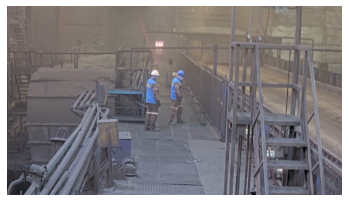

In [12]:
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt
DESIRED_HEIGHT = 1080
DESIRED_WIDTH = 1920
def resize_and_show(image):
    h, w = image.shape[:2]
    if h < w:
        img = cv2.resize(image, (DESIRED_WIDTH, math.floor(h/(w/DESIRED_WIDTH))))
    else:
        img = cv2.resize(image, (math.floor(w/(h/DESIRED_HEIGHT)), DESIRED_HEIGHT))
    plt.imshow(img)
    plt.axis("off")


image = cv2.imread('data_task2/train/images/' + df['img_id'].iloc[0])  
resize_and_show(image)

In [10]:
import mediapipe as mp
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils 
mp_drawing_styles = mp.solutions.drawing_styles

data_task2/train/images/am3_5_frame110.jpg
(1080, 1920, 3)


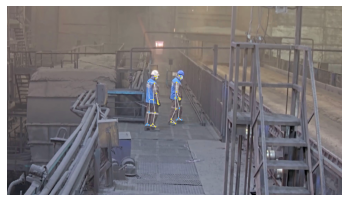

In [19]:
with mp_pose.Pose(
    static_image_mode=True, min_detection_confidence=0.5, model_complexity=2) as pose:
    # Convert the BGR image to RGB and process it with MediaPipe Pose.
    img_predict = get_detection_solution(path_to_test_images = 'data_task2/train/images/' + df['img_id'].iloc[0])
    for i in img_predict:
        box = i['bbox']
        img1 = image[box[1]:box[1] + box[3],box[0]:box[0] + box[2],:]
        results = pose.process(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))

        # Print nose landmark.
        image_hight, image_width, _ = img1.shape
        annotated_image = img1.copy()
        mp_drawing.draw_landmarks(
            annotated_image,
            results.pose_landmarks,
            mp_pose.POSE_CONNECTIONS,
            landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style())
        image[box[1]:box[1] + box[3],box[0]:box[0] + box[2],:] = annotated_image
resize_and_show(image)

In [25]:
for j in df['img_id'].values:
    image = cv2.imread('data_task2/train/images/' + j)
    with mp_pose.Pose(
        static_image_mode=True, min_detection_confidence=0.5, model_complexity=2) as pose:
    # Convert the BGR image to RGB and process it with MediaPipe Pose.
        img_predict = get_detection_solution(path_to_test_images = 'data_task2/train/images/' + j)
        for i in img_predict:
            box = i['bbox']
            img1 = image[box[1]:box[1] + box[3],box[0]:box[0] + box[2],:]
            results = pose.process(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))

            # Print nose landmark.
            image_hight, image_width, _ = img1.shape
            annotated_image = img1.copy()
            mp_drawing.draw_landmarks(
                annotated_image,
                results.pose_landmarks,
                mp_pose.POSE_CONNECTIONS,
                landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style())
            image[box[1]:box[1] + box[3],box[0]:box[0] + box[2],:] = annotated_image
    cv2.imwrite('data/' + j,image)

data_task2/train/images/am3_5_frame110.jpg
(1080, 1920, 3)
data_task2/train/images/oz7_frame511.jpg
(1080, 1920, 3)
data_task2/train/images/am3_6_violation_frame058.jpg
(1080, 1920, 3)
data_task2/train/images/oz7_frame430.jpg
(1080, 1920, 3)
data_task2/train/images/am3_9_violation_frame127.jpg
(1080, 1920, 3)
data_task2/train/images/am3_1_frame015.jpg
(1080, 1920, 3)
data_task2/train/images/oz7_frame016.jpg
(1080, 1920, 3)
data_task2/train/images/oz_frame527.jpg
(1080, 1920, 3)
data_task2/train/images/oz_frame446.jpg
(1080, 1920, 3)
data_task2/train/images/oz_frame086.jpg
(1080, 1920, 3)
data_task2/train/images/oz7_frame052.jpg
(1080, 1920, 3)
data_task2/train/images/oz7_frame241.jpg
(1080, 1920, 3)
data_task2/train/images/oz7_frame403.jpg
(1080, 1920, 3)
data_task2/train/images/oz_frame590.jpg
(1080, 1920, 3)
data_task2/train/images/am3_1_frame006.jpg
(1080, 1920, 3)
data_task2/train/images/oz_frame518.jpg
(1080, 1920, 3)
data_task2/train/images/oz7_frame520.jpg
(1080, 1920, 3)
data_t

In [26]:
!pip install timm
!pip install Albumentations

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
     |████████████████████████████████| 376 kB 26.7 MB/s eta 0:00:01
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
     |█████████

In [25]:
class CFG:
    debug=False
    apex=False
    print_freq=100
    num_workers=0
    model_name='tf_efficientnet_b0_ns'
    size=720
    scheduler='ReduceLROnPlateau' # ['ReduceLROnPlateau', 'CosineAnnealingLR', 'CosineAnnealingWarmRestarts']
    epochs=50
    factor=0.2 # ReduceLROnPlateau
    patience=5 # ReduceLROnPlateau
    eps=1e-6 # ReduceLROnPlateau
    #T_max=10 # CosineAnnealingLR
    T_0=10 # CosineAnnealingWarmRestarts
    lr=1e-4
    min_lr=1e-6
    batch_size=8
    weight_decay=1e-6
    gradient_accumulation_steps=1
    max_grad_norm=1000
    seed=42
    target_size=2
    target_col='label'
    n_fold=5
    trn_fold=[0]
    train=True
    inference=False
    
if CFG.debug:
    CFG.epochs = 1
    train = train.sample(n=1000, random_state=CFG.seed).reset_index(drop=True)

In [5]:
# ====================================================
# Library
# ====================================================
import sys

import os
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter

import scipy as sp
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

from tqdm.auto import tqdm
from functools import partial

import cv2
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
import torchvision.models as models
from torch.nn.parameter import Parameter
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau

from albumentations import (
    Compose, OneOf, Normalize, Resize, RandomCrop, HorizontalFlip, VerticalFlip, 
    RandomBrightness, RandomContrast, RandomBrightnessContrast, Rotate, ShiftScaleRotate, Cutout, 
    IAAAdditiveGaussianNoise, Transpose
    )
from albumentations.pytorch import ToTensorV2 
from albumentations import ImageOnlyTransform 

import timm

import warnings 
warnings.filterwarnings('ignore')

if CFG.apex:
    from apex import amp

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    return accuracy_score(y_true, y_pred)


@contextmanager
def timer(name):
    t0 = time.time()
    LOGGER.info(f'[{name}] start')
    yield
    LOGGER.info(f'[{name}] done in {time.time() - t0:.0f} s.')


def init_logger(log_file='train.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger()


def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(seed=CFG.seed)

In [8]:
train = df.copy()

In [9]:
folds = train.copy()
Fold = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
for n, (train_index, val_index) in enumerate(Fold.split(folds, folds[CFG.target_col])):
    folds.loc[val_index, 'fold'] = int(n)
folds['fold'] = folds['fold'].astype(int)
print(folds.groupby(['fold', CFG.target_col]).size())

fold  label
0     0        12
      1        88
1     0        12
      1        88
2     0        12
      1        88
3     0        12
      1        88
4     0        12
      1        88
dtype: int64


In [10]:
class TrainDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df['img_id'].values
        self.labels = df['label'].values
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        file_path = 'data/'+ file_name
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        label = torch.tensor(self.labels[idx]).long()
        return image, label
    

class TestDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df['img_id'].values
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        file_path = f'{TEST_PATH}/{file_name}'
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        return image

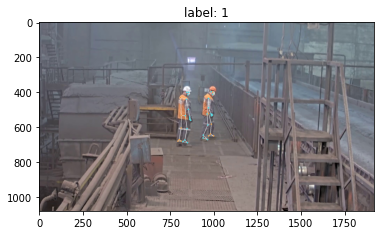

In [13]:
train_dataset = TrainDataset(train, transform=None)

for i in range(1):
    image, label = train_dataset[i]
    plt.imshow(image)
    plt.title(f'label: {label}')
    plt.show() 

In [14]:
# ====================================================
# Transforms
# ====================================================
def get_transforms(*, data):
    
    if data == 'train':
        return Compose([
            Resize(CFG.size, CFG.size),
            #RandomResizedCrop(CFG.size, CFG.size),
            Transpose(p=0.5),
            HorizontalFlip(p=0.5),
            VerticalFlip(p=0.5),
            ShiftScaleRotate(p=0.5),
            Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

    elif data == 'valid':
        return Compose([
            Resize(CFG.size, CFG.size),
            Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

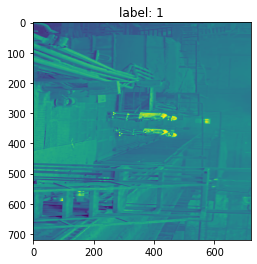

In [15]:
train_dataset = TrainDataset(train, transform=get_transforms(data='train'))

for i in range(1):
    image, label = train_dataset[i]
    plt.imshow(image[0])
    plt.title(f'label: {label}')
    plt.show() 

In [16]:
# ====================================================
# MODEL
# ====================================================
class CustomModel(nn.Module):
    def __init__(self, model_name='tf_efficientnet_b0_ns', pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)
        n_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(n_features, CFG.target_size)

    def forward(self, x):
        x = self.model(x)
        return x

In [17]:
model = CustomModel(model_name=CFG.model_name, pretrained=False)
train_dataset = TrainDataset(train, transform=get_transforms(data='train'))
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True,
                          num_workers=0, pin_memory=True, drop_last=True)

for image, label in train_loader:
    output = model(image)
    print(output)
    break

tensor([[-0.0814, -0.0591],
        [-0.0436, -0.0519],
        [-0.0438, -0.0365],
        [-0.0942, -0.0467]], grad_fn=<AddmmBackward0>)


In [18]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to train mode
    model.train()
    start = end = time.time()
    global_step = 0
    for step, (images, labels) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        y_preds = model(images)
        loss = criterion(y_preds, labels)
        # record loss
        losses.update(loss.item(), batch_size)
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        if CFG.apex:
            with amp.scale_loss(loss, optimizer) as scaled_loss:
                scaled_loss.backward()
        else:
            loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()
            global_step += 1
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  #'LR: {lr:.6f}  '
                  .format(
                   epoch+1, step, len(train_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses,
                   remain=timeSince(start, float(step+1)/len(train_loader)),
                   grad_norm=grad_norm,
                   #lr=scheduler.get_lr()[0],
                   ))
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to evaluation mode
    model.eval()
    preds = []
    start = end = time.time()
    for step, (images, labels) in enumerate(valid_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        # compute loss
        with torch.no_grad():
            y_preds = model(images)
        loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)
        # record accuracy
        preds.append(y_preds.softmax(1).to('cpu').numpy())
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(
                   step, len(valid_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses,
                   remain=timeSince(start, float(step+1)/len(valid_loader)),
                   ))
    predictions = np.concatenate(preds)
    return losses.avg, predictions


def inference(model, states, test_loader, device):
    model.to(device)
    tk0 = tqdm(enumerate(test_loader), total=len(test_loader))
    probs = []
    for i, (images) in tk0:
        images = images.to(device)
        avg_preds = []
        for state in states:
            model.load_state_dict(state['model'])
            model.eval()
            with torch.no_grad():
                y_preds = model(images)
            avg_preds.append(y_preds.softmax(1).to('cpu').numpy())
        avg_preds = np.mean(avg_preds, axis=0)
        probs.append(avg_preds)
    probs = np.concatenate(probs)
    return probs

In [27]:
# ====================================================
# Train loop
# ====================================================
def train_loop(folds, fold):

    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    trn_idx = folds[folds['fold'] != fold].index
    val_idx = folds[folds['fold'] == fold].index

    train_folds = folds.loc[trn_idx].reset_index(drop=True)
    valid_folds = folds.loc[val_idx].reset_index(drop=True)

    train_dataset = TrainDataset(train_folds, 
                                 transform=get_transforms(data='train'))
    valid_dataset = TrainDataset(valid_folds, 
                                 transform=get_transforms(data='valid'))

    train_loader = DataLoader(train_dataset, 
                              batch_size=CFG.batch_size, 
                              shuffle=True, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, 
                              batch_size=CFG.batch_size, 
                              shuffle=False, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)
    
    # ====================================================
    # scheduler 
    # ====================================================
    def get_scheduler(optimizer):
        if CFG.scheduler=='ReduceLROnPlateau':
            scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=CFG.factor, patience=CFG.patience, verbose=True, eps=CFG.eps)
        elif CFG.scheduler=='CosineAnnealingLR':
            scheduler = CosineAnnealingLR(optimizer, T_max=CFG.T_max, eta_min=CFG.min_lr, last_epoch=-1)
        elif CFG.scheduler=='CosineAnnealingWarmRestarts':
            scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG.T_0, T_mult=1, eta_min=CFG.min_lr, last_epoch=-1)
        return scheduler

    # ====================================================
    # model & optimizer
    # ====================================================
    model = CustomModel(CFG.model_name, pretrained=True)
    model.to(device)

    optimizer = Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay, amsgrad=False)
    scheduler = get_scheduler(optimizer)

    # ====================================================
    # apex
    # ====================================================
    if CFG.apex:
        model, optimizer = amp.initialize(model, optimizer, opt_level='O1', verbosity=0)

    # ====================================================
    # loop
    # ====================================================
    criterion = nn.CrossEntropyLoss()

    best_score = 0.
    best_loss = np.inf
    
    for epoch in range(CFG.epochs):
        
        start_time = time.time()
        
        # train
        avg_loss = train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # eval
        avg_val_loss, preds = valid_fn(valid_loader, model, criterion, device)
        valid_labels = valid_folds[CFG.target_col].values
        
        if isinstance(scheduler, ReduceLROnPlateau):
            scheduler.step(avg_val_loss)
        elif isinstance(scheduler, CosineAnnealingLR):
            scheduler.step()
        elif isinstance(scheduler, CosineAnnealingWarmRestarts):
            scheduler.step()

        # scoring
        score = get_score(valid_labels, preds.argmax(1))

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Accuracy: {score}')

        if score > best_score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save({'model': model.state_dict(), 
                        'preds': preds},
                        f'{CFG.model_name}_fold{fold}_best.pth')
    

    return valid_folds

In [23]:
def main():

    """
    Prepare: 1.train  2.test  3.submission  4.folds
    """

    def get_result(result_df):
        preds = result_df['preds'].values
        labels = result_df[CFG.target_col].values
        score = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.5f}')
    
    if CFG.train:
        # train 
        oof_df = pd.DataFrame()
        for fold in range(CFG.n_fold):
            if fold in CFG.trn_fold:
                train_loop(folds, fold)
 
    if CFG.inference:
        # inference
        model = CustomModel(CFG.model_name, pretrained=False)
        states = [torch.load(OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best.pth') for fold in CFG.trn_fold]
        test_dataset = TestDataset(test, transform=get_transforms(data='valid'))
        test_loader = DataLoader(test_dataset, batch_size=CFG.batch_size, shuffle=False, 
                                 num_workers=CFG.num_workers, pin_memory=True)
        predictions = inference(model, states, test_loader, device)
        # submission
        test['label'] = predictions.argmax(1)
        test[['image_id', 'label']].to_csv(OUTPUT_DIR+'submission.csv', index=False)

In [26]:
if __name__ == '__main__':
    main()

========== fold: 0 training ==========


Epoch: [1][0/50] Data 0.357 (0.357) Elapsed 0m 0s (remain 0m 39s) Loss: 0.6654(0.6654) Grad: 2.7430  
Epoch: [1][49/50] Data 0.325 (0.332) Elapsed 0m 36s (remain 0m 0s) Loss: 0.3141(0.4375) Grad: 1.0427  
EVAL: [0/13] Data 0.302 (0.302) Elapsed 0m 0s (remain 0m 4s) Loss: 0.3302(0.3302) 


Epoch 1 - avg_train_loss: 0.4375  avg_val_loss: 0.3843  time: 42s
Epoch 1 - Accuracy: 0.88
Epoch 1 - Save Best Score: 0.8800 Model


EVAL: [12/13] Data 0.145 (0.290) Elapsed 0m 5s (remain 0m 0s) Loss: 0.7940(0.3843) 
Epoch: [2][0/50] Data 0.335 (0.335) Elapsed 0m 0s (remain 0m 35s) Loss: 0.1234(0.1234) Grad: 0.8830  
Epoch: [2][49/50] Data 0.315 (0.333) Elapsed 0m 36s (remain 0m 0s) Loss: 0.4083(0.3675) Grad: 0.9021  
EVAL: [0/13] Data 0.301 (0.301) Elapsed 0m 0s (remain 0m 4s) Loss: 0.3634(0.3634) 


Epoch 2 - avg_train_loss: 0.3675  avg_val_loss: 0.3725  time: 42s
Epoch 2 - Accuracy: 0.88


EVAL: [12/13] Data 0.148 (0.293) Elapsed 0m 5s (remain 0m 0s) Loss: 0.5989(0.3725) 
Epoch: [3][0/50] Data 0.336 (0.336) Elapsed 0m 0s (remain 0m 36s) Loss: 0.3003(0.3003) Grad: 0.6481  
Epoch: [3][49/50] Data 0.330 (0.333) Elapsed 0m 36s (remain 0m 0s) Loss: 0.1143(0.3577) Grad: 0.7922  
EVAL: [0/13] Data 0.303 (0.303) Elapsed 0m 0s (remain 0m 4s) Loss: 0.3323(0.3323) 


Epoch 3 - avg_train_loss: 0.3577  avg_val_loss: 0.3891  time: 42s
Epoch 3 - Accuracy: 0.88


EVAL: [12/13] Data 0.145 (0.288) Elapsed 0m 5s (remain 0m 0s) Loss: 0.7466(0.3891) 
Epoch: [4][0/50] Data 0.343 (0.343) Elapsed 0m 0s (remain 0m 36s) Loss: 0.1121(0.1121) Grad: 0.7970  
Epoch: [4][49/50] Data 0.337 (0.335) Elapsed 0m 36s (remain 0m 0s) Loss: 0.1241(0.3559) Grad: 0.8102  
EVAL: [0/13] Data 0.306 (0.306) Elapsed 0m 0s (remain 0m 4s) Loss: 0.3975(0.3975) 


Epoch 4 - avg_train_loss: 0.3559  avg_val_loss: 0.3830  time: 42s
Epoch 4 - Accuracy: 0.88


EVAL: [12/13] Data 0.151 (0.293) Elapsed 0m 5s (remain 0m 0s) Loss: 0.7277(0.3830) 
Epoch: [5][0/50] Data 0.355 (0.355) Elapsed 0m 0s (remain 0m 37s) Loss: 0.1093(0.1093) Grad: 0.7789  
Epoch: [5][49/50] Data 0.336 (0.334) Elapsed 0m 36s (remain 0m 0s) Loss: 0.2113(0.3310) Grad: 1.1050  
EVAL: [0/13] Data 0.313 (0.313) Elapsed 0m 0s (remain 0m 5s) Loss: 0.3481(0.3481) 


Epoch 5 - avg_train_loss: 0.3310  avg_val_loss: 0.3654  time: 42s
Epoch 5 - Accuracy: 0.88


EVAL: [12/13] Data 0.146 (0.290) Elapsed 0m 5s (remain 0m 0s) Loss: 0.5090(0.3654) 
Epoch: [6][0/50] Data 0.330 (0.330) Elapsed 0m 0s (remain 0m 35s) Loss: 0.9379(0.9379) Grad: 2.8600  
Epoch: [6][49/50] Data 0.330 (0.333) Elapsed 0m 36s (remain 0m 0s) Loss: 0.7100(0.3432) Grad: 2.3802  
EVAL: [0/13] Data 0.312 (0.312) Elapsed 0m 0s (remain 0m 5s) Loss: 0.3586(0.3586) 


Epoch 6 - avg_train_loss: 0.3432  avg_val_loss: 0.3606  time: 42s
Epoch 6 - Accuracy: 0.88


EVAL: [12/13] Data 0.149 (0.296) Elapsed 0m 5s (remain 0m 0s) Loss: 0.6451(0.3606) 
Epoch: [7][0/50] Data 0.339 (0.339) Elapsed 0m 0s (remain 0m 36s) Loss: 0.2311(0.2311) Grad: 0.7908  
Epoch: [7][49/50] Data 0.353 (0.331) Elapsed 0m 36s (remain 0m 0s) Loss: 0.3544(0.3160) Grad: 1.5198  
EVAL: [0/13] Data 0.315 (0.315) Elapsed 0m 0s (remain 0m 5s) Loss: 0.4271(0.4271) 


Epoch 7 - avg_train_loss: 0.3160  avg_val_loss: 0.4028  time: 42s
Epoch 7 - Accuracy: 0.88


EVAL: [12/13] Data 0.150 (0.291) Elapsed 0m 5s (remain 0m 0s) Loss: 0.5023(0.4028) 
Epoch: [8][0/50] Data 0.342 (0.342) Elapsed 0m 0s (remain 0m 36s) Loss: 0.1528(0.1528) Grad: 0.9761  
Epoch: [8][49/50] Data 0.334 (0.333) Elapsed 0m 36s (remain 0m 0s) Loss: 0.3603(0.2947) Grad: 2.1060  
EVAL: [0/13] Data 0.301 (0.301) Elapsed 0m 0s (remain 0m 4s) Loss: 0.2482(0.2482) 


Epoch 8 - avg_train_loss: 0.2947  avg_val_loss: 0.3437  time: 42s
Epoch 8 - Accuracy: 0.88


EVAL: [12/13] Data 0.147 (0.289) Elapsed 0m 5s (remain 0m 0s) Loss: 0.5160(0.3437) 
Epoch: [9][0/50] Data 0.337 (0.337) Elapsed 0m 0s (remain 0m 36s) Loss: 0.1789(0.1789) Grad: 1.1652  
Epoch: [9][49/50] Data 0.334 (0.334) Elapsed 0m 36s (remain 0m 0s) Loss: 0.3552(0.2925) Grad: 2.5913  
EVAL: [0/13] Data 0.303 (0.303) Elapsed 0m 0s (remain 0m 4s) Loss: 0.2720(0.2720) 


Epoch 9 - avg_train_loss: 0.2925  avg_val_loss: 0.2925  time: 42s
Epoch 9 - Accuracy: 0.9
Epoch 9 - Save Best Score: 0.9000 Model


EVAL: [12/13] Data 0.145 (0.290) Elapsed 0m 5s (remain 0m 0s) Loss: 0.3819(0.2925) 
Epoch: [10][0/50] Data 0.314 (0.314) Elapsed 0m 0s (remain 0m 35s) Loss: 0.1976(0.1976) Grad: 1.2254  
Epoch: [10][49/50] Data 0.337 (0.333) Elapsed 0m 36s (remain 0m 0s) Loss: 0.2735(0.2424) Grad: 1.7479  
EVAL: [0/13] Data 0.304 (0.304) Elapsed 0m 0s (remain 0m 4s) Loss: 0.3395(0.3395) 


Epoch 10 - avg_train_loss: 0.2424  avg_val_loss: 0.2824  time: 42s
Epoch 10 - Accuracy: 0.9


EVAL: [12/13] Data 0.145 (0.289) Elapsed 0m 5s (remain 0m 0s) Loss: 0.1999(0.2824) 
Epoch: [11][0/50] Data 0.341 (0.341) Elapsed 0m 0s (remain 0m 37s) Loss: 0.1069(0.1069) Grad: 0.6525  
Epoch: [11][49/50] Data 0.344 (0.333) Elapsed 0m 37s (remain 0m 0s) Loss: 0.0982(0.2456) Grad: 0.8882  
EVAL: [0/13] Data 0.313 (0.313) Elapsed 0m 0s (remain 0m 5s) Loss: 0.4356(0.4356) 


Epoch 11 - avg_train_loss: 0.2456  avg_val_loss: 0.2216  time: 42s
Epoch 11 - Accuracy: 0.94
Epoch 11 - Save Best Score: 0.9400 Model


EVAL: [12/13] Data 0.146 (0.293) Elapsed 0m 5s (remain 0m 0s) Loss: 0.1405(0.2216) 
Epoch: [12][0/50] Data 0.321 (0.321) Elapsed 0m 0s (remain 0m 35s) Loss: 0.0952(0.0952) Grad: 0.7217  
Epoch: [12][49/50] Data 0.359 (0.335) Elapsed 0m 37s (remain 0m 0s) Loss: 0.6222(0.1913) Grad: 5.0788  
EVAL: [0/13] Data 0.315 (0.315) Elapsed 0m 0s (remain 0m 5s) Loss: 0.2232(0.2232) 


Epoch 12 - avg_train_loss: 0.1913  avg_val_loss: 0.2374  time: 42s
Epoch 12 - Accuracy: 0.87


EVAL: [12/13] Data 0.147 (0.295) Elapsed 0m 5s (remain 0m 0s) Loss: 0.1987(0.2374) 
Epoch: [13][0/50] Data 0.349 (0.349) Elapsed 0m 0s (remain 0m 37s) Loss: 0.0434(0.0434) Grad: 0.5184  
Epoch: [13][49/50] Data 0.328 (0.335) Elapsed 0m 37s (remain 0m 0s) Loss: 0.2380(0.1939) Grad: 2.7999  
EVAL: [0/13] Data 0.302 (0.302) Elapsed 0m 0s (remain 0m 4s) Loss: 0.3007(0.3007) 


Epoch 13 - avg_train_loss: 0.1939  avg_val_loss: 0.2269  time: 43s
Epoch 13 - Accuracy: 0.91


EVAL: [12/13] Data 0.144 (0.291) Elapsed 0m 5s (remain 0m 0s) Loss: 0.0558(0.2269) 
Epoch: [14][0/50] Data 0.330 (0.330) Elapsed 0m 0s (remain 0m 36s) Loss: 0.2530(0.2530) Grad: 2.3137  
Epoch: [14][49/50] Data 0.332 (0.336) Elapsed 0m 37s (remain 0m 0s) Loss: 0.0254(0.1669) Grad: 0.2231  
EVAL: [0/13] Data 0.302 (0.302) Elapsed 0m 0s (remain 0m 4s) Loss: 0.5899(0.5899) 


Epoch 14 - avg_train_loss: 0.1669  avg_val_loss: 0.1934  time: 43s
Epoch 14 - Accuracy: 0.91


EVAL: [12/13] Data 0.147 (0.292) Elapsed 0m 5s (remain 0m 0s) Loss: 0.0985(0.1934) 
Epoch: [15][0/50] Data 0.334 (0.334) Elapsed 0m 0s (remain 0m 36s) Loss: 0.2274(0.2274) Grad: 2.3320  
Epoch: [15][49/50] Data 0.344 (0.332) Elapsed 0m 37s (remain 0m 0s) Loss: 0.1013(0.1525) Grad: 1.7635  
EVAL: [0/13] Data 0.301 (0.301) Elapsed 0m 0s (remain 0m 4s) Loss: 0.6986(0.6986) 


Epoch 15 - avg_train_loss: 0.1525  avg_val_loss: 0.2444  time: 42s
Epoch 15 - Accuracy: 0.87


EVAL: [12/13] Data 0.147 (0.290) Elapsed 0m 5s (remain 0m 0s) Loss: 0.0223(0.2444) 
Epoch: [16][0/50] Data 0.335 (0.335) Elapsed 0m 0s (remain 0m 36s) Loss: 0.0657(0.0657) Grad: 1.5718  
Epoch: [16][49/50] Data 0.341 (0.331) Elapsed 0m 37s (remain 0m 0s) Loss: 0.2365(0.1274) Grad: 3.4184  
EVAL: [0/13] Data 0.302 (0.302) Elapsed 0m 0s (remain 0m 4s) Loss: 0.9137(0.9137) 


Epoch 16 - avg_train_loss: 0.1274  avg_val_loss: 0.2319  time: 42s
Epoch 16 - Accuracy: 0.9


EVAL: [12/13] Data 0.145 (0.292) Elapsed 0m 5s (remain 0m 0s) Loss: 0.0365(0.2319) 
Epoch: [17][0/50] Data 0.325 (0.325) Elapsed 0m 0s (remain 0m 36s) Loss: 0.0236(0.0236) Grad: 0.5324  
Epoch: [17][49/50] Data 0.332 (0.333) Elapsed 0m 37s (remain 0m 0s) Loss: 0.0496(0.0946) Grad: 1.5292  
EVAL: [0/13] Data 0.308 (0.308) Elapsed 0m 0s (remain 0m 4s) Loss: 0.7127(0.7127) 


Epoch 17 - avg_train_loss: 0.0946  avg_val_loss: 0.1808  time: 42s
Epoch 17 - Accuracy: 0.93


EVAL: [12/13] Data 0.150 (0.294) Elapsed 0m 5s (remain 0m 0s) Loss: 0.0142(0.1808) 
Epoch: [18][0/50] Data 0.337 (0.337) Elapsed 0m 0s (remain 0m 36s) Loss: 0.0871(0.0871) Grad: 2.4458  
Epoch: [18][49/50] Data 0.337 (0.333) Elapsed 0m 37s (remain 0m 0s) Loss: 0.1672(0.0938) Grad: 2.1368  
EVAL: [0/13] Data 0.300 (0.300) Elapsed 0m 0s (remain 0m 4s) Loss: 0.7590(0.7590) 


Epoch 18 - avg_train_loss: 0.0938  avg_val_loss: 0.4716  time: 42s
Epoch 18 - Accuracy: 0.79


EVAL: [12/13] Data 0.147 (0.292) Elapsed 0m 5s (remain 0m 0s) Loss: 0.1060(0.4716) 
Epoch: [19][0/50] Data 0.356 (0.356) Elapsed 0m 0s (remain 0m 37s) Loss: 0.0381(0.0381) Grad: 1.8716  
Epoch: [19][49/50] Data 0.355 (0.334) Elapsed 0m 37s (remain 0m 0s) Loss: 0.0178(0.1003) Grad: 0.6563  
EVAL: [0/13] Data 0.311 (0.311) Elapsed 0m 0s (remain 0m 5s) Loss: 0.6726(0.6726) 


Epoch 19 - avg_train_loss: 0.1003  avg_val_loss: 0.1800  time: 42s
Epoch 19 - Accuracy: 0.93


EVAL: [12/13] Data 0.145 (0.292) Elapsed 0m 5s (remain 0m 0s) Loss: 0.0104(0.1800) 
Epoch: [20][0/50] Data 0.326 (0.326) Elapsed 0m 0s (remain 0m 36s) Loss: 0.1127(0.1127) Grad: 3.1976  
Epoch: [20][49/50] Data 0.343 (0.331) Elapsed 0m 37s (remain 0m 0s) Loss: 0.0099(0.1091) Grad: 0.2214  
EVAL: [0/13] Data 0.299 (0.299) Elapsed 0m 0s (remain 0m 4s) Loss: 0.6983(0.6983) 


Epoch 20 - avg_train_loss: 0.1091  avg_val_loss: 0.1914  time: 42s
Epoch 20 - Accuracy: 0.93


EVAL: [12/13] Data 0.144 (0.288) Elapsed 0m 5s (remain 0m 0s) Loss: 0.0178(0.1914) 
Epoch: [21][0/50] Data 0.332 (0.332) Elapsed 0m 0s (remain 0m 36s) Loss: 0.0651(0.0651) Grad: 1.4009  
Epoch: [21][49/50] Data 0.341 (0.333) Elapsed 0m 37s (remain 0m 0s) Loss: 0.0282(0.1114) Grad: 0.6149  
EVAL: [0/13] Data 0.302 (0.302) Elapsed 0m 0s (remain 0m 4s) Loss: 0.6371(0.6371) 


Epoch 21 - avg_train_loss: 0.1114  avg_val_loss: 0.2322  time: 42s
Epoch 21 - Accuracy: 0.95
Epoch 21 - Save Best Score: 0.9500 Model


EVAL: [12/13] Data 0.148 (0.289) Elapsed 0m 5s (remain 0m 0s) Loss: 0.0280(0.2322) 
Epoch: [22][0/50] Data 0.339 (0.339) Elapsed 0m 0s (remain 0m 36s) Loss: 0.0285(0.0285) Grad: 0.7450  
Epoch: [22][49/50] Data 0.338 (0.333) Elapsed 0m 37s (remain 0m 0s) Loss: 0.0038(0.0650) Grad: 0.0709  
EVAL: [0/13] Data 0.298 (0.298) Elapsed 0m 0s (remain 0m 4s) Loss: 0.3791(0.3791) 


Epoch 22 - avg_train_loss: 0.0650  avg_val_loss: 0.3082  time: 42s
Epoch 22 - Accuracy: 0.91


EVAL: [12/13] Data 0.146 (0.291) Elapsed 0m 5s (remain 0m 0s) Loss: 0.0079(0.3082) 
Epoch: [23][0/50] Data 0.325 (0.325) Elapsed 0m 0s (remain 0m 36s) Loss: 0.0237(0.0237) Grad: 0.3765  
Epoch: [23][49/50] Data 0.335 (0.332) Elapsed 0m 37s (remain 0m 0s) Loss: 0.0126(0.0844) Grad: 0.3203  
EVAL: [0/13] Data 0.301 (0.301) Elapsed 0m 0s (remain 0m 4s) Loss: 0.7347(0.7347) 


Epoch 23 - avg_train_loss: 0.0844  avg_val_loss: 0.2653  time: 42s
Epoch 23 - Accuracy: 0.91


EVAL: [12/13] Data 0.149 (0.288) Elapsed 0m 5s (remain 0m 0s) Loss: 0.0101(0.2653) 
Epoch: [24][0/50] Data 0.332 (0.332) Elapsed 0m 0s (remain 0m 36s) Loss: 0.0251(0.0251) Grad: 0.6489  
Epoch: [24][49/50] Data 0.316 (0.329) Elapsed 0m 37s (remain 0m 0s) Loss: 0.0109(0.1018) Grad: 0.1520  
EVAL: [0/13] Data 0.299 (0.299) Elapsed 0m 0s (remain 0m 4s) Loss: 1.0384(1.0384) 


Epoch 24 - avg_train_loss: 0.1018  avg_val_loss: 0.2702  time: 42s
Epoch 24 - Accuracy: 0.93


EVAL: [12/13] Data 0.144 (0.289) Elapsed 0m 5s (remain 0m 0s) Loss: 0.0045(0.2702) 
Epoch: [25][0/50] Data 0.313 (0.313) Elapsed 0m 0s (remain 0m 35s) Loss: 0.0163(0.0163) Grad: 0.1853  
Epoch: [25][49/50] Data 0.331 (0.332) Elapsed 0m 37s (remain 0m 0s) Loss: 0.0510(0.0833) Grad: 1.5602  
EVAL: [0/13] Data 0.300 (0.300) Elapsed 0m 0s (remain 0m 4s) Loss: 0.8378(0.8378) 


Epoch 25 - avg_train_loss: 0.0833  avg_val_loss: 0.2205  time: 42s
Epoch 25 - Accuracy: 0.9


EVAL: [12/13] Data 0.145 (0.288) Elapsed 0m 5s (remain 0m 0s) Loss: 0.0019(0.2205) 
Epoch    25: reducing learning rate of group 0 to 2.0000e-05.
Epoch: [26][0/50] Data 0.333 (0.333) Elapsed 0m 0s (remain 0m 36s) Loss: 0.0093(0.0093) Grad: 0.1676  
Epoch: [26][49/50] Data 0.339 (0.333) Elapsed 0m 36s (remain 0m 0s) Loss: 0.0166(0.0555) Grad: 0.4498  
EVAL: [0/13] Data 0.300 (0.300) Elapsed 0m 0s (remain 0m 4s) Loss: 0.7573(0.7573) 


Epoch 26 - avg_train_loss: 0.0555  avg_val_loss: 0.2508  time: 42s
Epoch 26 - Accuracy: 0.9


EVAL: [12/13] Data 0.146 (0.290) Elapsed 0m 5s (remain 0m 0s) Loss: 0.0030(0.2508) 
Epoch: [27][0/50] Data 0.323 (0.323) Elapsed 0m 0s (remain 0m 35s) Loss: 0.0179(0.0179) Grad: 0.3055  
Epoch: [27][49/50] Data 0.335 (0.331) Elapsed 0m 36s (remain 0m 0s) Loss: 0.0130(0.0399) Grad: 0.4317  
EVAL: [0/13] Data 0.314 (0.314) Elapsed 0m 0s (remain 0m 5s) Loss: 0.6936(0.6936) 


Epoch 27 - avg_train_loss: 0.0399  avg_val_loss: 0.2691  time: 42s
Epoch 27 - Accuracy: 0.92


EVAL: [12/13] Data 0.146 (0.291) Elapsed 0m 5s (remain 0m 0s) Loss: 0.0079(0.2691) 
Epoch: [28][0/50] Data 0.336 (0.336) Elapsed 0m 0s (remain 0m 36s) Loss: 0.0068(0.0068) Grad: 0.1584  
Epoch: [28][49/50] Data 0.331 (0.334) Elapsed 0m 36s (remain 0m 0s) Loss: 0.0291(0.0404) Grad: 1.0957  
EVAL: [0/13] Data 0.303 (0.303) Elapsed 0m 0s (remain 0m 4s) Loss: 0.6570(0.6570) 


Epoch 28 - avg_train_loss: 0.0404  avg_val_loss: 0.2785  time: 42s
Epoch 28 - Accuracy: 0.94


EVAL: [12/13] Data 0.146 (0.288) Elapsed 0m 5s (remain 0m 0s) Loss: 0.0170(0.2785) 
Epoch: [29][0/50] Data 0.348 (0.348) Elapsed 0m 0s (remain 0m 37s) Loss: 0.0246(0.0246) Grad: 0.5504  
Epoch: [29][49/50] Data 0.319 (0.334) Elapsed 0m 36s (remain 0m 0s) Loss: 0.0045(0.0613) Grad: 0.1300  
EVAL: [0/13] Data 0.304 (0.304) Elapsed 0m 0s (remain 0m 4s) Loss: 0.6399(0.6399) 


Epoch 29 - avg_train_loss: 0.0613  avg_val_loss: 0.2730  time: 42s
Epoch 29 - Accuracy: 0.9


EVAL: [12/13] Data 0.146 (0.288) Elapsed 0m 5s (remain 0m 0s) Loss: 0.0053(0.2730) 
Epoch: [30][0/50] Data 0.350 (0.350) Elapsed 0m 0s (remain 0m 37s) Loss: 0.0081(0.0081) Grad: 0.1567  
Epoch: [30][49/50] Data 0.338 (0.332) Elapsed 0m 36s (remain 0m 0s) Loss: 0.0033(0.0262) Grad: 0.0528  
EVAL: [0/13] Data 0.299 (0.299) Elapsed 0m 0s (remain 0m 4s) Loss: 0.6922(0.6922) 


Epoch 30 - avg_train_loss: 0.0262  avg_val_loss: 0.2564  time: 42s
Epoch 30 - Accuracy: 0.91


EVAL: [12/13] Data 0.145 (0.287) Elapsed 0m 5s (remain 0m 0s) Loss: 0.0047(0.2564) 
Epoch: [31][0/50] Data 0.346 (0.346) Elapsed 0m 0s (remain 0m 36s) Loss: 0.0017(0.0017) Grad: 0.0294  
Epoch: [31][49/50] Data 0.334 (0.334) Elapsed 0m 36s (remain 0m 0s) Loss: 0.0109(0.0350) Grad: 0.4507  
EVAL: [0/13] Data 0.301 (0.301) Elapsed 0m 0s (remain 0m 4s) Loss: 0.7587(0.7587) 


Epoch 31 - avg_train_loss: 0.0350  avg_val_loss: 0.2539  time: 42s
Epoch 31 - Accuracy: 0.92


EVAL: [12/13] Data 0.147 (0.288) Elapsed 0m 5s (remain 0m 0s) Loss: 0.0048(0.2539) 
Epoch    31: reducing learning rate of group 0 to 4.0000e-06.
Epoch: [32][0/50] Data 0.340 (0.340) Elapsed 0m 0s (remain 0m 36s) Loss: 0.0065(0.0065) Grad: 0.1593  
Epoch: [32][49/50] Data 0.331 (0.333) Elapsed 0m 36s (remain 0m 0s) Loss: 0.0049(0.0213) Grad: 0.0819  
EVAL: [0/13] Data 0.305 (0.305) Elapsed 0m 0s (remain 0m 4s) Loss: 0.7693(0.7693) 


Epoch 32 - avg_train_loss: 0.0213  avg_val_loss: 0.2499  time: 42s
Epoch 32 - Accuracy: 0.93


EVAL: [12/13] Data 0.145 (0.288) Elapsed 0m 5s (remain 0m 0s) Loss: 0.0042(0.2499) 
Epoch: [33][0/50] Data 0.330 (0.330) Elapsed 0m 0s (remain 0m 36s) Loss: 0.0078(0.0078) Grad: 0.2990  
Epoch: [33][49/50] Data 0.330 (0.330) Elapsed 0m 36s (remain 0m 0s) Loss: 0.0055(0.0277) Grad: 0.1794  
EVAL: [0/13] Data 0.299 (0.299) Elapsed 0m 0s (remain 0m 4s) Loss: 0.7957(0.7957) 


Epoch 33 - avg_train_loss: 0.0277  avg_val_loss: 0.2545  time: 42s
Epoch 33 - Accuracy: 0.92


EVAL: [12/13] Data 0.149 (0.288) Elapsed 0m 5s (remain 0m 0s) Loss: 0.0043(0.2545) 
Epoch: [34][0/50] Data 0.332 (0.332) Elapsed 0m 0s (remain 0m 35s) Loss: 0.0730(0.0730) Grad: 1.8883  
Epoch: [34][49/50] Data 0.351 (0.336) Elapsed 0m 36s (remain 0m 0s) Loss: 0.0043(0.0270) Grad: 0.0724  
EVAL: [0/13] Data 0.303 (0.303) Elapsed 0m 0s (remain 0m 4s) Loss: 0.7582(0.7582) 


Epoch 34 - avg_train_loss: 0.0270  avg_val_loss: 0.2458  time: 42s
Epoch 34 - Accuracy: 0.89


EVAL: [12/13] Data 0.145 (0.291) Elapsed 0m 5s (remain 0m 0s) Loss: 0.0033(0.2458) 
Epoch: [35][0/50] Data 0.335 (0.335) Elapsed 0m 0s (remain 0m 35s) Loss: 0.0197(0.0197) Grad: 0.5094  
Epoch: [35][49/50] Data 0.326 (0.331) Elapsed 0m 36s (remain 0m 0s) Loss: 0.0186(0.0332) Grad: 0.3411  
EVAL: [0/13] Data 0.315 (0.315) Elapsed 0m 0s (remain 0m 5s) Loss: 0.7883(0.7883) 


Epoch 35 - avg_train_loss: 0.0332  avg_val_loss: 0.2604  time: 42s
Epoch 35 - Accuracy: 0.92


EVAL: [12/13] Data 0.145 (0.291) Elapsed 0m 5s (remain 0m 0s) Loss: 0.0057(0.2604) 
Epoch: [36][0/50] Data 0.336 (0.336) Elapsed 0m 0s (remain 0m 36s) Loss: 0.0321(0.0321) Grad: 1.0265  
Epoch: [36][49/50] Data 0.319 (0.329) Elapsed 0m 36s (remain 0m 0s) Loss: 0.0118(0.0326) Grad: 0.5174  
EVAL: [0/13] Data 0.300 (0.300) Elapsed 0m 0s (remain 0m 4s) Loss: 0.7494(0.7494) 


Epoch 36 - avg_train_loss: 0.0326  avg_val_loss: 0.2468  time: 42s
Epoch 36 - Accuracy: 0.91


EVAL: [12/13] Data 0.146 (0.293) Elapsed 0m 5s (remain 0m 0s) Loss: 0.0051(0.2468) 
Epoch: [37][0/50] Data 0.326 (0.326) Elapsed 0m 0s (remain 0m 35s) Loss: 0.0034(0.0034) Grad: 0.0868  
Epoch: [37][49/50] Data 0.339 (0.331) Elapsed 0m 36s (remain 0m 0s) Loss: 0.0177(0.0443) Grad: 0.5620  
EVAL: [0/13] Data 0.301 (0.301) Elapsed 0m 0s (remain 0m 4s) Loss: 0.7216(0.7216) 


Epoch 37 - avg_train_loss: 0.0443  avg_val_loss: 0.2532  time: 42s
Epoch 37 - Accuracy: 0.91


EVAL: [12/13] Data 0.146 (0.289) Elapsed 0m 5s (remain 0m 0s) Loss: 0.0047(0.2532) 
Epoch    37: reducing learning rate of group 0 to 8.0000e-07.
Epoch: [38][0/50] Data 0.327 (0.327) Elapsed 0m 0s (remain 0m 35s) Loss: 0.0031(0.0031) Grad: 0.0575  
Epoch: [38][49/50] Data 0.328 (0.332) Elapsed 0m 36s (remain 0m 0s) Loss: 0.0118(0.0378) Grad: 0.4867  
EVAL: [0/13] Data 0.300 (0.300) Elapsed 0m 0s (remain 0m 4s) Loss: 0.7923(0.7923) 


Epoch 38 - avg_train_loss: 0.0378  avg_val_loss: 0.2642  time: 42s
Epoch 38 - Accuracy: 0.91


EVAL: [12/13] Data 0.148 (0.290) Elapsed 0m 5s (remain 0m 0s) Loss: 0.0037(0.2642) 
Epoch: [39][0/50] Data 0.318 (0.318) Elapsed 0m 0s (remain 0m 35s) Loss: 0.0036(0.0036) Grad: 0.0851  
Epoch: [39][49/50] Data 0.336 (0.332) Elapsed 0m 36s (remain 0m 0s) Loss: 0.0065(0.0244) Grad: 0.1483  
EVAL: [0/13] Data 0.312 (0.312) Elapsed 0m 0s (remain 0m 5s) Loss: 0.7037(0.7037) 


Epoch 39 - avg_train_loss: 0.0244  avg_val_loss: 0.2560  time: 42s
Epoch 39 - Accuracy: 0.94


EVAL: [12/13] Data 0.150 (0.292) Elapsed 0m 5s (remain 0m 0s) Loss: 0.0081(0.2560) 
Epoch: [40][0/50] Data 0.332 (0.332) Elapsed 0m 0s (remain 0m 36s) Loss: 0.0025(0.0025) Grad: 0.0415  
Epoch: [40][49/50] Data 0.330 (0.332) Elapsed 0m 37s (remain 0m 0s) Loss: 0.0028(0.0217) Grad: 0.0565  
EVAL: [0/13] Data 0.310 (0.310) Elapsed 0m 0s (remain 0m 5s) Loss: 0.8067(0.8067) 


Epoch 40 - avg_train_loss: 0.0217  avg_val_loss: 0.2647  time: 42s
Epoch 40 - Accuracy: 0.9


EVAL: [12/13] Data 0.145 (0.289) Elapsed 0m 5s (remain 0m 0s) Loss: 0.0041(0.2647) 
Epoch: [41][0/50] Data 0.334 (0.334) Elapsed 0m 0s (remain 0m 36s) Loss: 0.0625(0.0625) Grad: 2.3875  
Epoch: [41][49/50] Data 0.327 (0.331) Elapsed 0m 37s (remain 0m 0s) Loss: 0.0735(0.0263) Grad: 3.2036  
EVAL: [0/13] Data 0.302 (0.302) Elapsed 0m 0s (remain 0m 4s) Loss: 0.7459(0.7459) 


Epoch 41 - avg_train_loss: 0.0263  avg_val_loss: 0.2630  time: 42s
Epoch 41 - Accuracy: 0.94


EVAL: [12/13] Data 0.146 (0.290) Elapsed 0m 5s (remain 0m 0s) Loss: 0.0064(0.2630) 
Epoch: [42][0/50] Data 0.340 (0.340) Elapsed 0m 0s (remain 0m 37s) Loss: 0.0601(0.0601) Grad: 2.0104  
Epoch: [42][49/50] Data 0.318 (0.331) Elapsed 0m 37s (remain 0m 0s) Loss: 0.0643(0.0440) Grad: 2.6102  
EVAL: [0/13] Data 0.303 (0.303) Elapsed 0m 0s (remain 0m 4s) Loss: 0.8309(0.8309) 


Epoch 42 - avg_train_loss: 0.0440  avg_val_loss: 0.2590  time: 42s
Epoch 42 - Accuracy: 0.9


EVAL: [12/13] Data 0.145 (0.289) Elapsed 0m 5s (remain 0m 0s) Loss: 0.0029(0.2590) 
Epoch: [43][0/50] Data 0.335 (0.335) Elapsed 0m 0s (remain 0m 36s) Loss: 0.0052(0.0052) Grad: 0.1243  
Epoch: [43][49/50] Data 0.331 (0.334) Elapsed 0m 37s (remain 0m 0s) Loss: 0.0086(0.0297) Grad: 0.4030  
EVAL: [0/13] Data 0.302 (0.302) Elapsed 0m 0s (remain 0m 4s) Loss: 0.8054(0.8054) 


Epoch 43 - avg_train_loss: 0.0297  avg_val_loss: 0.2647  time: 42s
Epoch 43 - Accuracy: 0.9


EVAL: [12/13] Data 0.146 (0.287) Elapsed 0m 5s (remain 0m 0s) Loss: 0.0034(0.2647) 
Epoch: [44][0/50] Data 0.348 (0.348) Elapsed 0m 0s (remain 0m 37s) Loss: 0.0049(0.0049) Grad: 0.1186  
Epoch: [44][49/50] Data 0.351 (0.333) Elapsed 0m 37s (remain 0m 0s) Loss: 0.0690(0.0316) Grad: 2.3154  
EVAL: [0/13] Data 0.299 (0.299) Elapsed 0m 0s (remain 0m 4s) Loss: 0.7737(0.7737) 


Epoch 44 - avg_train_loss: 0.0316  avg_val_loss: 0.2790  time: 42s
Epoch 44 - Accuracy: 0.94


EVAL: [12/13] Data 0.145 (0.291) Elapsed 0m 5s (remain 0m 0s) Loss: 0.0075(0.2790) 
Epoch: [45][0/50] Data 0.320 (0.320) Elapsed 0m 0s (remain 0m 36s) Loss: 0.0045(0.0045) Grad: 0.0835  
Epoch: [45][49/50] Data 0.333 (0.330) Elapsed 0m 37s (remain 0m 0s) Loss: 0.0045(0.0313) Grad: 0.1228  
EVAL: [0/13] Data 0.314 (0.314) Elapsed 0m 0s (remain 0m 5s) Loss: 0.7995(0.7995) 


Epoch 45 - avg_train_loss: 0.0313  avg_val_loss: 0.2638  time: 42s
Epoch 45 - Accuracy: 0.91


EVAL: [12/13] Data 0.145 (0.289) Elapsed 0m 5s (remain 0m 0s) Loss: 0.0043(0.2638) 
Epoch: [46][0/50] Data 0.323 (0.323) Elapsed 0m 0s (remain 0m 35s) Loss: 0.0021(0.0021) Grad: 0.0413  
Epoch: [46][49/50] Data 0.324 (0.330) Elapsed 0m 37s (remain 0m 0s) Loss: 0.0085(0.0284) Grad: 0.3290  
EVAL: [0/13] Data 0.312 (0.312) Elapsed 0m 0s (remain 0m 5s) Loss: 0.8306(0.8306) 


Epoch 46 - avg_train_loss: 0.0284  avg_val_loss: 0.2801  time: 42s
Epoch 46 - Accuracy: 0.9


EVAL: [12/13] Data 0.146 (0.293) Elapsed 0m 5s (remain 0m 0s) Loss: 0.0034(0.2801) 
Epoch: [47][0/50] Data 0.326 (0.326) Elapsed 0m 0s (remain 0m 36s) Loss: 0.0203(0.0203) Grad: 1.2211  
Epoch: [47][49/50] Data 0.331 (0.330) Elapsed 0m 36s (remain 0m 0s) Loss: 0.0059(0.0247) Grad: 0.1307  
EVAL: [0/13] Data 0.303 (0.303) Elapsed 0m 0s (remain 0m 4s) Loss: 0.8385(0.8385) 


Epoch 47 - avg_train_loss: 0.0247  avg_val_loss: 0.2633  time: 42s
Epoch 47 - Accuracy: 0.9


EVAL: [12/13] Data 0.150 (0.292) Elapsed 0m 5s (remain 0m 0s) Loss: 0.0034(0.2633) 
Epoch: [48][0/50] Data 0.341 (0.341) Elapsed 0m 0s (remain 0m 37s) Loss: 0.0075(0.0075) Grad: 0.2190  
Epoch: [48][49/50] Data 0.325 (0.331) Elapsed 0m 36s (remain 0m 0s) Loss: 0.0136(0.0187) Grad: 0.3821  
EVAL: [0/13] Data 0.304 (0.304) Elapsed 0m 0s (remain 0m 4s) Loss: 0.7828(0.7828) 


Epoch 48 - avg_train_loss: 0.0187  avg_val_loss: 0.2753  time: 42s
Epoch 48 - Accuracy: 0.92


EVAL: [12/13] Data 0.145 (0.292) Elapsed 0m 5s (remain 0m 0s) Loss: 0.0056(0.2753) 
Epoch: [49][0/50] Data 0.338 (0.338) Elapsed 0m 0s (remain 0m 36s) Loss: 0.0087(0.0087) Grad: 0.2763  
Epoch: [49][49/50] Data 0.335 (0.332) Elapsed 0m 36s (remain 0m 0s) Loss: 0.0050(0.0241) Grad: 0.2053  
EVAL: [0/13] Data 0.301 (0.301) Elapsed 0m 0s (remain 0m 4s) Loss: 0.7849(0.7849) 


Epoch 49 - avg_train_loss: 0.0241  avg_val_loss: 0.2624  time: 42s
Epoch 49 - Accuracy: 0.91


EVAL: [12/13] Data 0.146 (0.287) Elapsed 0m 5s (remain 0m 0s) Loss: 0.0040(0.2624) 
Epoch: [50][0/50] Data 0.319 (0.319) Elapsed 0m 0s (remain 0m 35s) Loss: 0.0143(0.0143) Grad: 0.3561  
Epoch: [50][49/50] Data 0.317 (0.333) Elapsed 0m 36s (remain 0m 0s) Loss: 0.0736(0.0299) Grad: 4.9396  
EVAL: [0/13] Data 0.302 (0.302) Elapsed 0m 0s (remain 0m 4s) Loss: 0.7940(0.7940) 


Epoch 50 - avg_train_loss: 0.0299  avg_val_loss: 0.2623  time: 42s
Epoch 50 - Accuracy: 0.9


EVAL: [12/13] Data 0.149 (0.293) Elapsed 0m 5s (remain 0m 0s) Loss: 0.0045(0.2623) 


KeyError: "None of [Index(['0'], dtype='object')] are in the [columns]"

In [56]:

def detect_danger(imagepath):
    label = ['Danger', 'Safe']
    image = cv2.imread(imagepath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image,(720,720))
    #image = Normalize(image)
    image =image / 255.0;
    image -=[0.485, 0.456, 0.406]
    image /=[0.229, 0.224, 0.225]
    image = np.transpose(image,(2,0,1))
    image = np.expand_dims(image,0)
    image = torch.from_numpy(image)
    model = CustomModel(model_name=CFG.model_name, pretrained=False)
    state = torch.load('tf_efficientnet_b0_ns_fold0_best.pth')
    model.load_state_dict(state['model'])
    model.eval()
    res = model(image.float())
    idx = 1
    if res.softmax(1).detach().numpy()[0][0] > 0.2:
        idx = 0
    print(label[idx])

In [57]:
detect_danger('data_task2/test/images/am3_5_violation_frame111.jpg')

Danger


In [58]:
detect_danger('data_task2/test/images/am3_1_frame043.jpg')

Safe


In [59]:
detect_danger('data_task2/test/images/am3_6_violation_frame059.jpg')

Danger


In [60]:
detect_danger('data_task2/test/images/am3_7_violation_frame139.jpg')

Danger


In [61]:
detect_danger('data_task2/test/images/am3_7_violation_frame140.jpg')

Danger


In [62]:
detect_danger('data_task2/test/images/am3_7_frame146.jpg')

Safe


In [63]:
detect_danger('data_task2/test/images/oz_violation_frame451.jpg')

Danger
